<a href="https://colab.research.google.com/github/julidoominguez/SeriesdeTiempoAustral/blob/main/TP2_Vitalcer_Chronos_TimeGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chronos

In [25]:
! pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-fs3ot5ix
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-fs3ot5ix
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit eb7bdfc047de3e7af972b4ee7cf23a7968b7daa3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12

Importamos librerias

In [26]:
from chronos import ChronosPipeline

In [1]:
## Librerias
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Cargamos los datos

In [27]:
# URL de la hoja de Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1OVJRz3bjcKnrTl62DdEbvJTrMlDYCLFmRILtqNJgTvs/edit?usp=sharing"

# Convertir la URL a un formato que pandas pueda leer
csv_url = sheet_url.replace('/edit?usp=sharing', '/export?format=csv')

# Leer los datos en un DataFrame de pandas
df_vitalcer = pd.read_csv(csv_url)

In [28]:
# Convertir la columna 'fecha' a datetime y establecerla como índice
df_vitalcer['fecha'] = pd.to_datetime(df_vitalcer['fecha'])
df_vitalcer.set_index('fecha', inplace=True)

In [29]:
# Convertir todas las columnas excepto el índice a tipo numérico
for col in df_vitalcer.columns:
    if df_vitalcer[col].dtype == 'object':
        df_vitalcer[col] = df_vitalcer[col].str.replace(',', '.')
        df_vitalcer[col] = pd.to_numeric(df_vitalcer[col], errors='coerce')

In [30]:
# Imputar valores nulos en las columnas 'Visitas pagina' y 'Alcance IG' con 0
df_vitalcer['Visitas pagina'].fillna(0, inplace=True)
df_vitalcer['Alcance IG'].fillna(0, inplace=True)

In [31]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


Configuramos el modelo chronos

In [32]:
from chronos import ChronosPipeline
import torch

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # Puedes cambiar a "amazon/chronos-t5-tiny" si es necesario
    device_map="cpu",
    torch_dtype=torch.float16,
)

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [33]:
# Preparación de los datos de entrada
# Aquí consideramos que los datos son diarios
df_vitalcer_daily = df_vitalcer.resample('D').mean().fillna(method='ffill')

# Extraemos la serie temporal de 'Monto_deflactado'
series = df_vitalcer_daily['Monto_deflactado'].values

In [34]:
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

# Dividimos los datos en entrenamiento y prueba
train_size = int(len(series) * 0.8)
train_series = series[:train_size]
test_series = series[train_size:]

# Convertir a DataFrame de pandas si no lo es
if isinstance(train_series, np.ndarray):
    train_series = pd.DataFrame(train_series, columns=['Monto_deflactado'])
    train_series.index = pd.date_range(start=df_vitalcer.index[0], periods=len(train_series), freq='D')

# Parametros de prediccion
step_to_predict = 30  # Da la cantidad de pasos hacia adelante que vamos a predecir
samples_to_consider = 30  # Da cuántos puntos de datos históricos se deben considerar al hacer la predicción

# Proyección
forecast = pipeline.predict(
    context=torch.tensor(train_series['Monto_deflactado'].values),
    prediction_length=step_to_predict,
    num_samples=samples_to_consider,
)

forecast_index = pd.date_range(start=train_series.index[-1] + pd.Timedelta(days=1), periods=step_to_predict, freq='D')
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

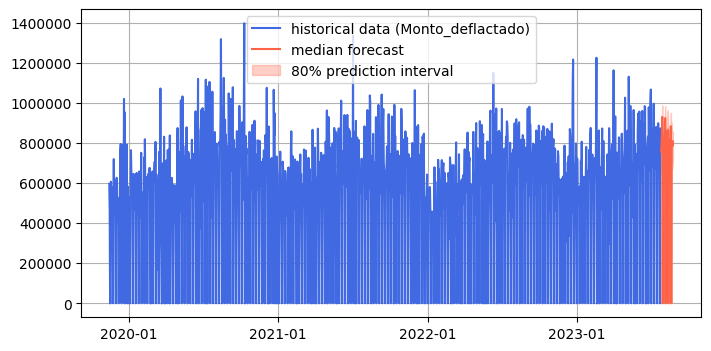

In [35]:
# Gráfico
plt.figure(figsize=(8, 4))
plt.plot(train_series.index, train_series['Monto_deflactado'], color="royalblue", label="historical data (Monto_deflactado)")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")

# Formatear el eje y
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Formatear el eje x como fecha
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.legend()
plt.grid()
plt.show()

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Obtener la mediana y los intervalos de confianza
forecast_np = forecast[0].numpy()
median_forecast = np.median(forecast_np, axis=0)
low, high = np.percentile(forecast_np, [10, 90], axis=0)

# Asegurarse de que test_series tiene la misma longitud que median_forecast
test_series_segment = test_series[:step_to_predict]

# Calcular las métricas de error
rmse = mean_squared_error(test_series_segment, median_forecast, squared=False)
mae = mean_absolute_error(test_series_segment, median_forecast)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 175082.15494789561
MAE: 102646.22253708697


# Time GPT

In [6]:
!pip install nixtla
!pip install nixtlats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 3.1 MB/s eta 0:00:00


In [7]:
from nixtlats import TimeGPT
from nixtlats import NixtlaClient
from nixtla import NixtlaClient

In [8]:
nixtla_client = NixtlaClient(


    api_key = 'nixtla-tok-ogZnA14LnuGFqtxLeKOvKYkZzcRcY9f30olaDjRYLT3PmUNuxn6oiyXHbxA1pMnC0rj7VoDISdTZ32gd'

)

In [39]:
# Cargar datos de Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1OVJRz3bjcKnrTl62DdEbvJTrMlDYCLFmRILtqNJgTvs/edit?usp=sharing"
csv_url = sheet_url.replace('/edit?usp=sharing', '/export?format=csv')
df_vitalcer = pd.read_csv(csv_url)

In [40]:
df_vitalcer['fecha'] = pd.to_datetime(df_vitalcer['fecha'])
df_vitalcer.set_index('fecha', inplace=True)

# Convertir todas las columnas a tipo numérico
for col in df_vitalcer.columns:
    if df_vitalcer[col].dtype == 'object':
        df_vitalcer[col] = df_vitalcer[col].str.replace(',', '.')
        df_vitalcer[col] = pd.to_numeric(df_vitalcer[col], errors='coerce')

In [41]:
# Imputar valores nulos en las columnas 'Visitas pagina' y 'Alcance IG' con 0
df_vitalcer['Visitas pagina'].fillna(0, inplace=True)
df_vitalcer['Alcance IG'].fillna(0, inplace=True)

In [42]:
# Aquí consideramos que los datos son diarios
df_vitalcer_daily = df_vitalcer.resample('D').mean().fillna(method='ffill')

In [43]:
df_vitalcer_daily.reset_index(inplace=True)
df_vitalcer_daily.rename(columns={'fecha': 'ds'}, inplace=True)

In [44]:
df_vitalcer_daily.rename(columns={'Monto_deflactado': 'y'}, inplace=True)

In [154]:
timegpt_fcst_df = nixtla_client.forecast(df=df_vitalcer_daily, h=6, time_col='ds', target_col='y', freq='D')
timegpt_fcst_df

,ds,TimeGPT
0,2024-06-28,718739.43750
1,2024-06-29,597349.93750
2,2024-06-30,234996.06250
3,2024-07-01,383262.90625
4,2024-07-02,765690.93750
5,2024-07-03,779058.18750


Cross validation



In [155]:
timegpt_cv_df = nixtla_client.cross_validation(
    df_vitalcer_daily,
    h=7,
    n_windows=5,
    time_col='ds',
    target_col='y',
    freq='D',
    level=[80, 90],
    date_features=['month'],
)
timegpt_cv_df.head()

,ds,cutoff,y,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,2024-05-24,2024-05-23,846620,744408.302593,394075.538803,502227.927208,9.865887e+05,1.094741e+06
1,2024-05-25,2024-05-23,532810,890186.089905,470802.992160,537297.323915,1.243075e+06,1.309569e+06
2,2024-05-26,2024-05-23,0,12055.241724,-280468.420776,-226075.078589,2.501856e+05,3.045789e+05
3,2024-05-27,2024-05-23,550170,455193.746181,-44202.092669,22923.179671,8.874643e+05,9.545896e+05
4,2024-05-28,2024-05-23,742040,627039.929828,367056.966615,430994.894168,8.230850e+05,8.870229e+05


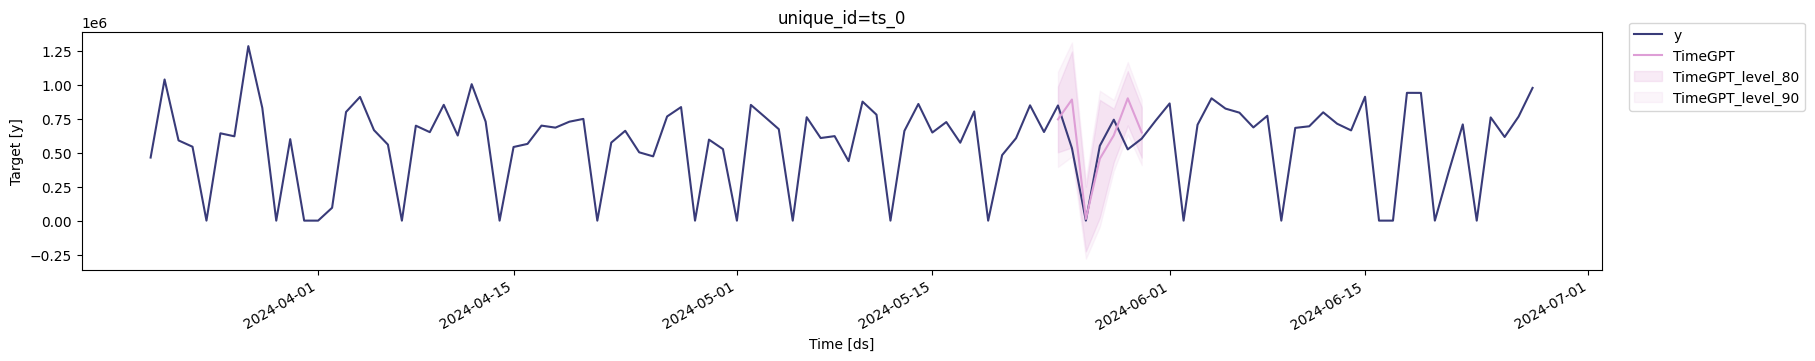

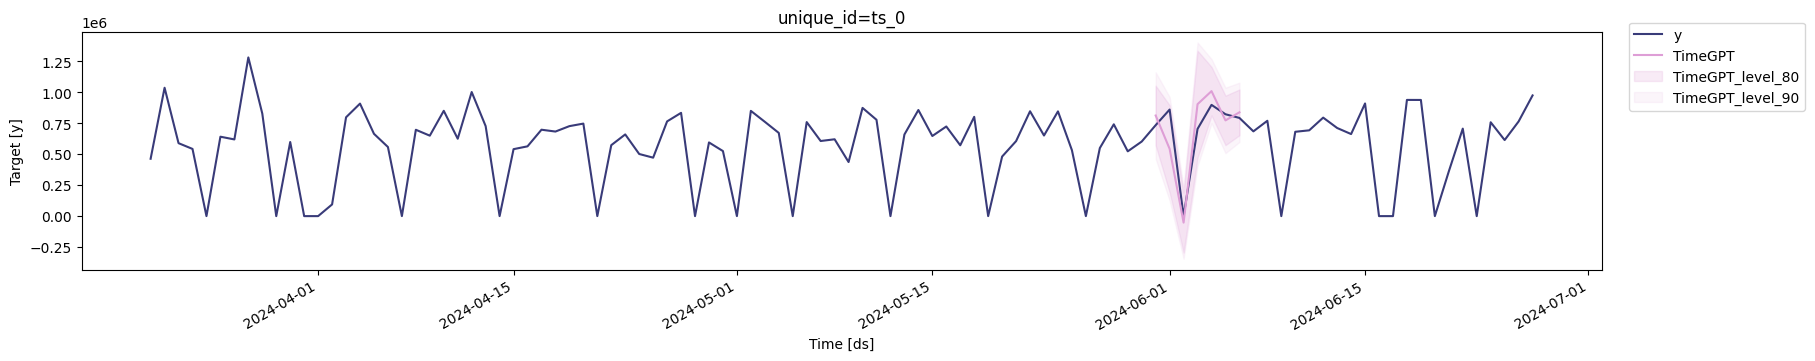

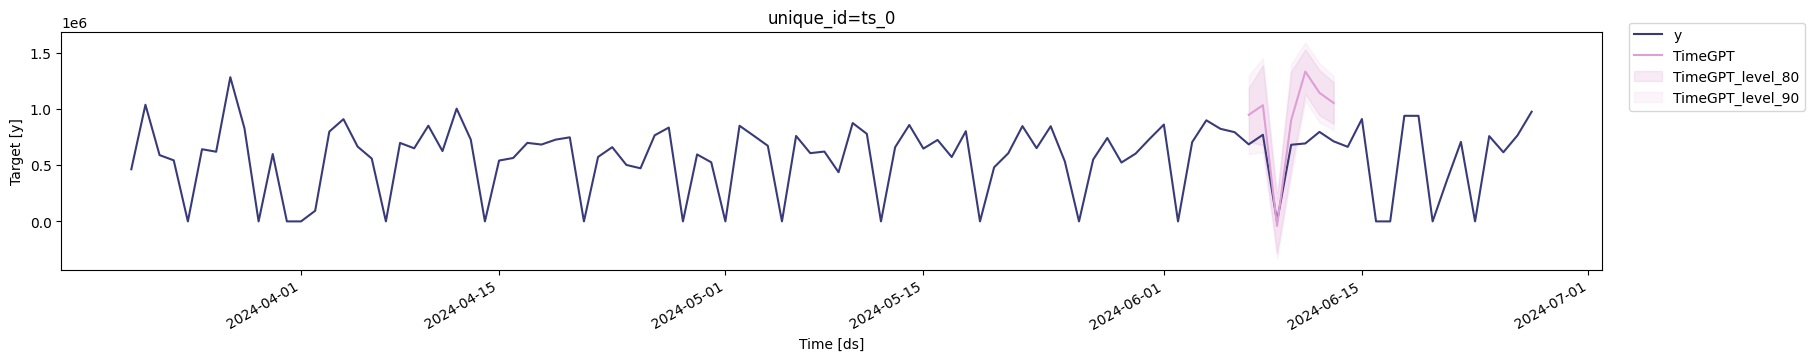

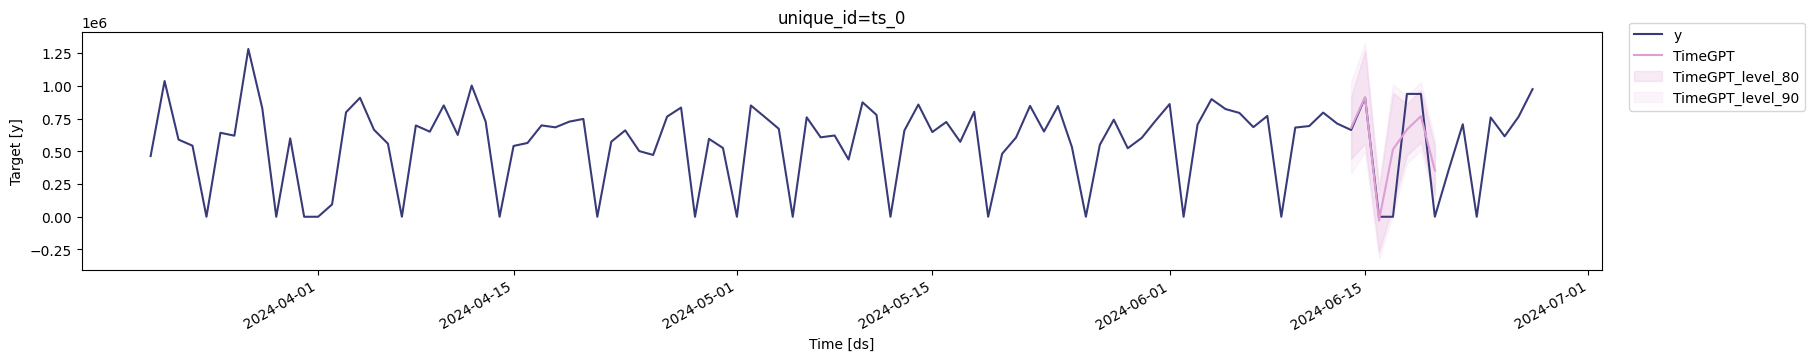

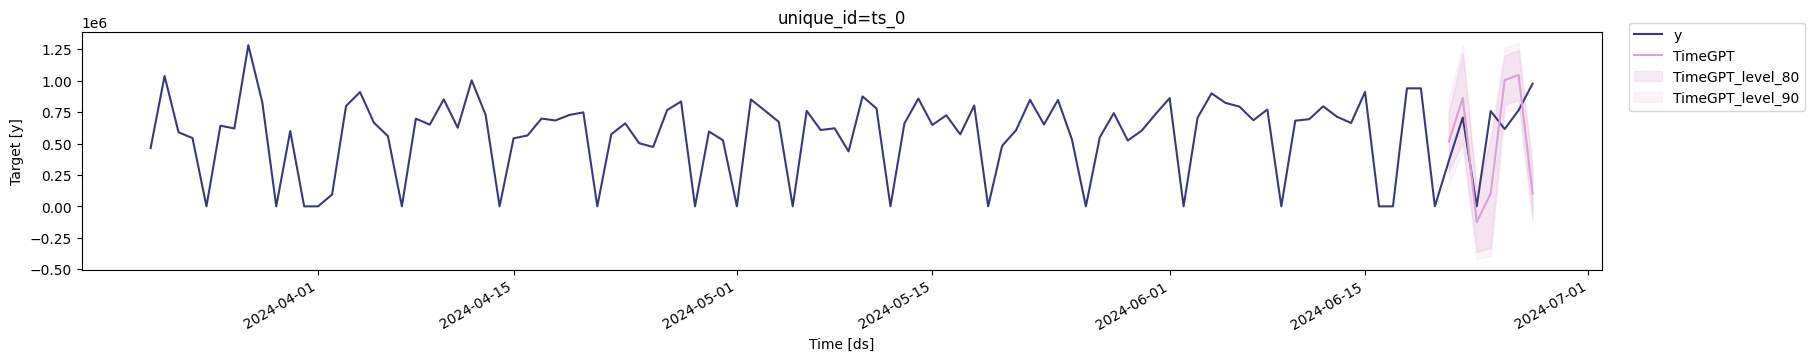

In [156]:
cutoffs = timegpt_cv_df['cutoff'].unique()
for cutoff in cutoffs:
    fig = nixtla_client.plot(
        df_vitalcer_daily.tail(100),
        timegpt_cv_df.query('cutoff == @cutoff').drop(columns=['cutoff', 'y']),
        time_col='ds',
        target_col='y',
        level=[80, 90],
        models=['TimeGPT']
    )
    display(fig)

Forecast



In [93]:
display(df_vitalcer_daily)

,ds,y,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,...,verduleria_fruteria,alimentos_preparados_rotiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronicos_articulos_hogar,otros,Visitas pagina,Alcance IG,is_holiday,is_closed
0,2019-11-15,595695.0318,62.0,66.94,3867.0,49574.33,239.44,243.40,246.54,238.13,...,2.838732e+06,8.830499e+05,1.131602e+07,2.197595e+06,4.638018e+06,7.726584e+06,0.0,0.0,False,False
1,2019-11-16,460448.3130,60.0,75.19,3867.0,49574.33,239.44,243.40,246.54,238.13,...,2.838732e+06,8.830499e+05,1.131602e+07,2.197595e+06,4.638018e+06,7.726584e+06,0.0,0.0,False,False
2,2019-11-17,0.0000,0.0,0.00,3867.0,49574.33,239.44,243.40,246.54,238.13,...,2.838732e+06,8.830499e+05,1.131602e+07,2.197595e+06,4.638018e+06,7.726584e+06,0.0,0.0,False,True
3,2019-11-18,0.0000,0.0,0.00,3867.0,49574.33,239.44,243.40,246.54,238.13,...,2.838732e+06,8.830499e+05,1.131602e+07,2.197595e+06,4.638018e+06,7.726584e+06,0.0,0.0,False,True
4,2019-11-19,606252.4772,88.0,73.75,3867.0,49574.33,239.44,243.40,246.54,238.13,...,2.838732e+06,8.830499e+05,1.131602e+07,2.197595e+06,4.638018e+06,7.726584e+06,0.0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682,2024-06-23,0.0000,0.0,0.00,7952.0,879483.08,4077.32,4490.03,4807.34,3957.89,...,6.057195e+07,1.362809e+07,2.074576e+08,3.429209e+07,6.509640e+07,8.558742e+07,10.0,4.0,False,True
1683,2024-06-24,758690.0000,64.0,81.62,29191.0,879483.08,4077.32,4490.03,4807.34,3957.89,...,6.057195e+07,1.362809e+07,2.074576e+08,3.429209e+07,6.509640e+07,8.558742e+07,26.0,12.0,False,False
1684,2024-06-25,614865.0000,64.0,85.44,28699.0,879483.08,4077.32,4490.03,4807.34,3957.89,...,6.057195e+07,1.362809e+07,2.074576e+08,3.429209e+07,6.509640e+07,8.558742e+07,25.0,15.0,False,False
1685,2024-06-26,765132.0000,66.0,82.25,29018.0,879483.08,4077.32,4490.03,4807.34,3957.89,...,6.057195e+07,1.362809e+07,2.074576e+08,3.429209e+07,6.509640e+07,8.558742e+07,32.0,13.0,False,False


In [45]:
# Filtrar el conjunto de datos hasta el 31 de diciembre de 2023 para `train`
train = df_vitalcer_daily[df_vitalcer_daily.ds <= '2024-05-26'].copy()

# Filtrar el conjunto de datos a partir del 1 de enero de 2024 para `future`
future = df_vitalcer_daily[df_vitalcer_daily.ds > '2024-05-26'].copy()

# Eliminar la columna 'Monto_deflactado' de `future` para usarlo como variables exógenas
future = future.drop(columns=['y'])

In [82]:
display(train)

,ds,y,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,...,verduleria_fruteria,alimentos_preparados_rotiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronicos_articulos_hogar,otros,Visitas pagina,Alcance IG,is_holiday,is_closed
0,2019-11-15,595695.0318,62.0,66.94,3867.0,49574.33,239.44,243.40,246.54,238.13,...,2.838732e+06,8.830499e+05,1.131602e+07,2.197595e+06,4.638018e+06,7.726584e+06,0.0,0.0,False,False
1,2019-11-16,460448.3130,60.0,75.19,3867.0,49574.33,239.44,243.40,246.54,238.13,...,2.838732e+06,8.830499e+05,1.131602e+07,2.197595e+06,4.638018e+06,7.726584e+06,0.0,0.0,False,False
2,2019-11-17,0.0000,0.0,0.00,3867.0,49574.33,239.44,243.40,246.54,238.13,...,2.838732e+06,8.830499e+05,1.131602e+07,2.197595e+06,4.638018e+06,7.726584e+06,0.0,0.0,False,True
3,2019-11-18,0.0000,0.0,0.00,3867.0,49574.33,239.44,243.40,246.54,238.13,...,2.838732e+06,8.830499e+05,1.131602e+07,2.197595e+06,4.638018e+06,7.726584e+06,0.0,0.0,False,True
4,2019-11-19,606252.4772,88.0,73.75,3867.0,49574.33,239.44,243.40,246.54,238.13,...,2.838732e+06,8.830499e+05,1.131602e+07,2.197595e+06,4.638018e+06,7.726584e+06,0.0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,2024-06-16,0.0000,0.0,0.00,8183.0,879483.08,4077.32,4490.03,4807.34,3957.89,...,6.057195e+07,1.362809e+07,2.074576e+08,3.429209e+07,6.509640e+07,8.558742e+07,21.0,3.0,False,True
1676,2024-06-17,0.0000,0.0,0.00,9504.0,879483.08,4077.32,4490.03,4807.34,3957.89,...,6.057195e+07,1.362809e+07,2.074576e+08,3.429209e+07,6.509640e+07,8.558742e+07,12.0,9.0,False,True
1677,2024-06-18,939330.0000,65.0,90.69,30024.0,879483.08,4077.32,4490.03,4807.34,3957.89,...,6.057195e+07,1.362809e+07,2.074576e+08,3.429209e+07,6.509640e+07,8.558742e+07,29.0,16.0,False,False
1678,2024-06-19,939040.0000,65.0,87.12,30834.0,879483.08,4077.32,4490.03,4807.34,3957.89,...,6.057195e+07,1.362809e+07,2.074576e+08,3.429209e+07,6.509640e+07,8.558742e+07,36.0,15.0,False,False


In [55]:
display(future)

,ds,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,indice_salarios_no_registrado_sector_privado,...,lacteos,carnes,verduleria_fruteria,alimentos_preparados_rotiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronicos_articulos_hogar,otros,Visitas pagina,Alcance IG
1680,2024-06-21,70.0,92.38,8872.0,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,170075429.1,153950342.7,60571949.32,13628091.52,207457595.6,34292093.85,65096403.31,85587417.6,25.0,4.0
1681,2024-06-22,79.0,92.94,13967.0,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,170075429.1,153950342.7,60571949.32,13628091.52,207457595.6,34292093.85,65096403.31,85587417.6,14.0,7.0
1682,2024-06-23,0.0,0.00,7952.0,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,170075429.1,153950342.7,60571949.32,13628091.52,207457595.6,34292093.85,65096403.31,85587417.6,10.0,4.0
1683,2024-06-24,64.0,81.62,29191.0,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,170075429.1,153950342.7,60571949.32,13628091.52,207457595.6,34292093.85,65096403.31,85587417.6,26.0,12.0
1684,2024-06-25,64.0,85.44,28699.0,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,170075429.1,153950342.7,60571949.32,13628091.52,207457595.6,34292093.85,65096403.31,85587417.6,25.0,15.0
1685,2024-06-26,66.0,82.25,29018.0,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,170075429.1,153950342.7,60571949.32,13628091.52,207457595.6,34292093.85,65096403.31,85587417.6,32.0,13.0
1686,2024-06-27,62.0,77.06,28542.0,879483.08,4077.32,4490.03,4807.34,3957.89,2419.24,...,170075429.1,153950342.7,60571949.32,13628091.52,207457595.6,34292093.85,65096403.31,85587417.6,46.0,6.0


In [158]:
h = len(future)

# Forecast using a 90% confidence interval
forecast_df = nixtla_client.forecast(
    df=train,
    X_df=future,
    h=h,
    time_col='ds',
    target_col="y",
    level=[90]
)

In [159]:
forecast_df['TimeGPT'] = forecast_df['TimeGPT'].clip(lower=0)

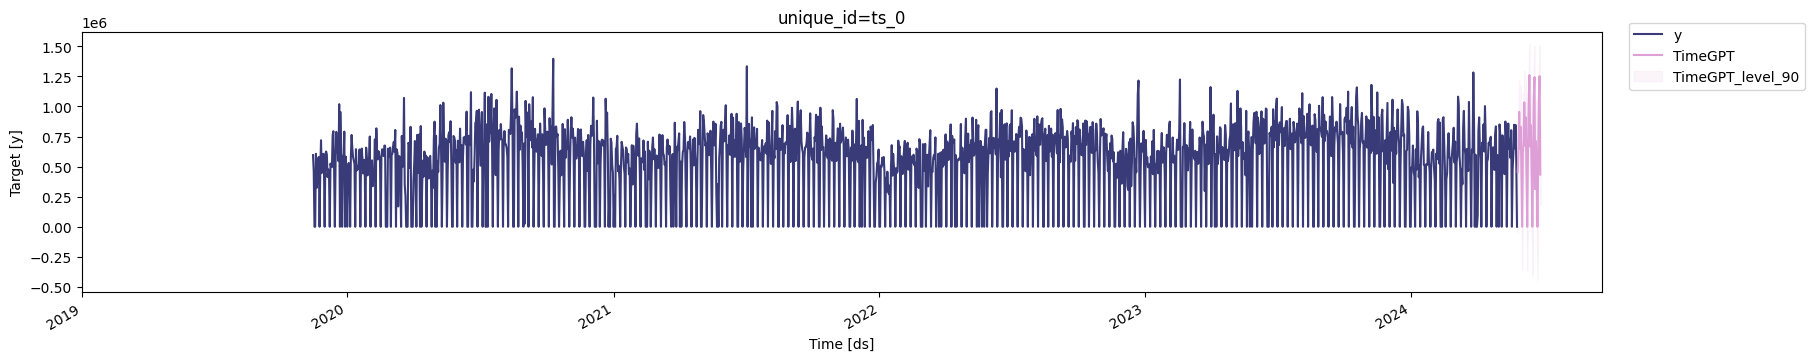

In [160]:
# Plot predictions with intervals
nixtla_client.plot(
    df=train,
    forecasts_df=forecast_df,
    time_col='ds',
    target_col='y',
    level=[90]
)

In [161]:
# Filtrar las fechas posteriores a 2024-05-26 para obtener los valores reales de 'y'
real_values = df_vitalcer_daily[df_vitalcer_daily['ds'] > '2024-05-26'].set_index('ds')['y']

In [162]:
# Establecer 'ds' como índice en forecast_df
forecast_df.set_index('ds', inplace=True)

In [163]:
display(forecast_df)

,TimeGPT,TimeGPT-lo-90,TimeGPT-hi-90
ds,,,
2024-05-27,4.551914e+05,-49325.255151,9.597080e+05
2024-05-28,6.235794e+05,367989.160318,8.791696e+05
2024-05-29,9.547585e+05,692003.911310,1.217513e+06
2024-05-30,6.485060e+05,396796.641082,9.002153e+05
2024-05-31,8.312732e+05,487362.454861,1.175184e+06
2024-06-01,4.823150e+05,35422.300052,9.292076e+05
2024-06-02,0.000000e+00,-356809.517337,2.087696e+05
2024-06-03,6.096897e+05,105173.099122,1.114206e+06
2024-06-04,7.211128e+05,465522.584653,9.767030e+05


In [164]:
display(real_values)

,y
ds,
2024-05-27,550170.0
2024-05-28,742040.0
2024-05-29,523769.0
2024-05-30,602735.0
2024-05-31,735305.0
2024-06-01,861440.0
2024-06-02,0.0
2024-06-03,704910.0
2024-06-04,899240.0


In [132]:
print(forecast_df.index)
print(real_values.index)

DatetimeIndex(['2024-05-27', '2024-05-28', '2024-05-29', '2024-05-30',
               '2024-05-31', '2024-06-01', '2024-06-02', '2024-06-03',
               '2024-06-04', '2024-06-05', '2024-06-06', '2024-06-07',
               '2024-06-08', '2024-06-09', '2024-06-10', '2024-06-11',
               '2024-06-12', '2024-06-13', '2024-06-14', '2024-06-15',
               '2024-06-16', '2024-06-17', '2024-06-18', '2024-06-19',
               '2024-06-20', '2024-06-21', '2024-06-22', '2024-06-23',
               '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27'],
              dtype='datetime64[ns]', name='ds', freq=None)
DatetimeIndex(['2024-05-27', '2024-05-28', '2024-05-29', '2024-05-30',
               '2024-05-31', '2024-06-01', '2024-06-02', '2024-06-03',
               '2024-06-04', '2024-06-05', '2024-06-06', '2024-06-07',
               '2024-06-08', '2024-06-09', '2024-06-10', '2024-06-11',
               '2024-06-12', '2024-06-13', '2024-06-14', '2024-06-15',
               '

In [165]:
forecast_df.index = pd.to_datetime(forecast_df.index)
real_values.index = pd.to_datetime(real_values.index)

In [166]:
# Filtrar las fechas que coinciden entre las predicciones y los valores reales
predicted_values = forecast_df.loc[real_values.index, 'TimeGPT']

In [167]:
display(predicted_values)

,TimeGPT
ds,
2024-05-27,4.551914e+05
2024-05-28,6.235794e+05
2024-05-29,9.547585e+05
2024-05-30,6.485060e+05
2024-05-31,8.312732e+05
2024-06-01,4.823150e+05
2024-06-02,0.000000e+00
2024-06-03,6.096897e+05
2024-06-04,7.211128e+05


In [168]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular RMSE y MAE
rmse = mean_squared_error(real_values, predicted_values, squared=False)
mae = mean_absolute_error(real_values, predicted_values)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


RMSE: 280601.91774654295
MAE: 229006.71611565785


Modelo simple sin variables exogenas

In [17]:
h = len(future)

# Forecast using a 90% confidence interval
forecast_df = nixtla_client.forecast(
    df=train,
    h=h,
    time_col='ds',
    target_col="y",
    level=[90]
)

In [18]:
forecast_df['TimeGPT'] = forecast_df['TimeGPT'].clip(lower=0)

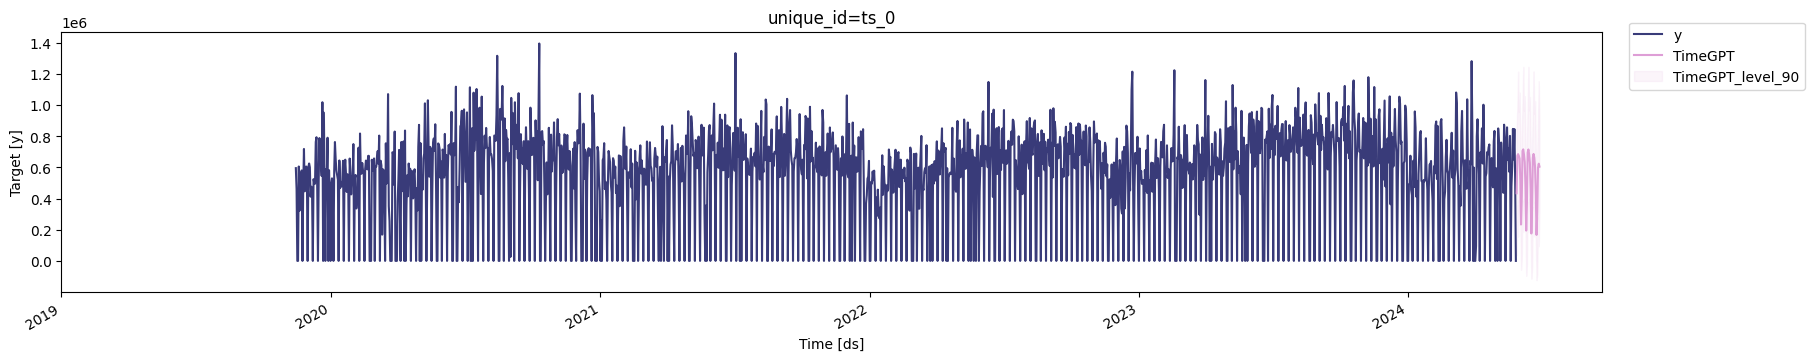

In [19]:
# Plot predictions with intervals
nixtla_client.plot(
    df=train,
    forecasts_df=forecast_df,
    time_col='ds',
    target_col='y',
    level=[90]
)

In [20]:
# Filtrar las fechas posteriores a 2024-05-26 para obtener los valores reales de 'y'
real_values = df_vitalcer_daily[df_vitalcer_daily['ds'] > '2024-05-26'].set_index('ds')['y']

In [21]:
# Establecer 'ds' como índice en forecast_df
forecast_df.set_index('ds', inplace=True)

In [22]:
forecast_df.index = pd.to_datetime(forecast_df.index)
real_values.index = pd.to_datetime(real_values.index)

In [23]:
# Filtrar las fechas que coinciden entre las predicciones y los valores reales
predicted_values = forecast_df.loc[real_values.index, 'TimeGPT']

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular RMSE y MAE
rmse = mean_squared_error(real_values, predicted_values, squared=False)
mae = mean_absolute_error(real_values, predicted_values)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 253399.43949816222
MAE: 205933.8818359375


Modelo con determinadas variables exógenas



In [47]:
# Seleccionar las columnas que quieres mantener
columnas_a_incluir = ['ds', 'y', 'sube', 'RH2M', 'dieta', 'Ventas Minoristas', 'ventas_precios_constantes']

# Crear el nuevo DataFrame filtrado
df_vitalcer_filtered = df_vitalcer_daily[columnas_a_incluir].copy()

In [48]:
# Filtrar el conjunto de datos hasta el 31 de diciembre de 2023 para `train`
train = df_vitalcer_filtered[df_vitalcer_filtered.ds <= '2024-05-26'].copy()

# Filtrar el conjunto de datos a partir del 1 de enero de 2024 para `future`
future = df_vitalcer_filtered[df_vitalcer_filtered.ds > '2024-05-26'].copy()

# Eliminar la columna 'y' de `future` para usarlo como variables exógenas
future = future.drop(columns=['y'])

In [49]:
h = len(future)

# Forecast using a 90% confidence interval
forecast_df = nixtla_client.forecast(
    df=train,
    X_df=future,
    h=h,
    time_col='ds',
    target_col="y",
    level=[90]
)

In [50]:
forecast_df['TimeGPT'] = forecast_df['TimeGPT'].clip(lower=0)

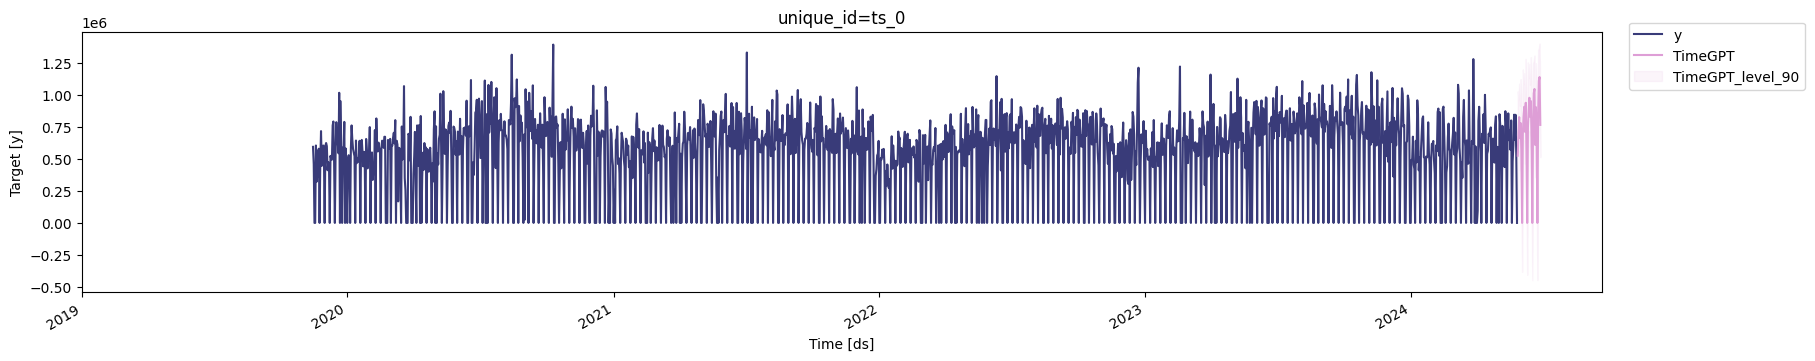

In [51]:
# Plot predictions with intervals
nixtla_client.plot(
    df=train,
    forecasts_df=forecast_df,
    time_col='ds',
    target_col='y',
    level=[90]
)

In [52]:
# Filtrar las fechas posteriores a 2024-05-26 para obtener los valores reales de 'y'
real_values = df_vitalcer_daily[df_vitalcer_daily['ds'] > '2024-05-26'].set_index('ds')['y']

In [53]:
# Establecer 'ds' como índice en forecast_df
forecast_df.set_index('ds', inplace=True)

In [54]:
forecast_df.index = pd.to_datetime(forecast_df.index)
real_values.index = pd.to_datetime(real_values.index)

In [55]:
# Filtrar las fechas que coinciden entre las predicciones y los valores reales
predicted_values = forecast_df.loc[real_values.index, 'TimeGPT']

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular RMSE y MAE
rmse = mean_squared_error(real_values, predicted_values, squared=False)
mae = mean_absolute_error(real_values, predicted_values)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 264417.4773250805
MAE: 183378.04266061704
